# Beta Bank Project

## Purpose

The purpose of this project is to develop a model that predicts whether a Beta Bank customer will leave the bank soon. The model will be trained based on data from previous clients' behavior and past terminations. The model must have an F1 Score of at least 0.59.

## Table of Contents
<a href='#General Data Information'>General Data Information</a>

<a href='#Feature Preparation'>Feature Preparation</a>

<a href='#Model Development'>Model Development</a>

<a href='#Class Balance'>Class Balance</a>

<a href='#Imbalanced Model Training'>Imbalanced Model Training</a>

<a href='#Class Balancing'>Class Balancing</a>

<a href='#Final Model Selection and Training'>Final Model Selection and Training</a>

<a href='#Conclusion'>Conclusion</a>

<a id='General Data Information'></a>
## General Data Information

Initially, a general look at the data is performed and the necessary sklearn modules are imported. Since the target attribute is categorical (customer either exited their contract or not), classification modules are imported for Decision Tree, Random Forest, and Logistic Regression.

In [28]:
#Import necessary libraries and modules
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import scipy as sc
from scipy import stats as st
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, mean_squared_error, f1_score, roc_curve, roc_auc_score
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.dummy import DummyClassifier
from sklearn.preprocessing import OrdinalEncoder, StandardScaler, LabelEncoder
from sklearn.utils import shuffle

In [29]:
data = pd.read_csv('/datasets/Churn.csv')

data.info()

data.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 14 columns):
RowNumber          10000 non-null int64
CustomerId         10000 non-null int64
Surname            10000 non-null object
CreditScore        10000 non-null int64
Geography          10000 non-null object
Gender             10000 non-null object
Age                10000 non-null int64
Tenure             9091 non-null float64
Balance            10000 non-null float64
NumOfProducts      10000 non-null int64
HasCrCard          10000 non-null int64
IsActiveMember     10000 non-null int64
EstimatedSalary    10000 non-null float64
Exited             10000 non-null int64
dtypes: float64(3), int64(8), object(3)
memory usage: 1.1+ MB


,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,1,15634602,Hargrave,619,France,Female,42,2.0,0.00,1,1,1,101348.88,1
1,2,15647311,Hill,608,Spain,Female,41,1.0,83807.86,1,0,1,112542.58,0
2,3,15619304,Onio,502,France,Female,42,8.0,159660.80,3,1,0,113931.57,1
3,4,15701354,Boni,699,France,Female,39,1.0,0.00,2,0,0,93826.63,0
4,5,15737888,Mitchell,850,Spain,Female,43,2.0,125510.82,1,1,1,79084.10,0


From the initial look at the data, it can be seen that there are some missing values in the `Tenure` attribute. These missing values are filled in with the median value of the `Tenure` attribute since there doesn't seem to be a logical reason why they are missing.

In [30]:
#Fills all missing values in Tenure column with the median value
data['Tenure'].fillna(data['Tenure'].median(), inplace = True)

<a id='Feature Preparation'></a>
### Feature Preparation

Out of the dataset attributes provided, there are three attributes that are the object type that must be converted to numerical features in order to use the classification methods to train the model. This will be accomplished by Label Encoding the dataset, which will convert all of the attributes to a numerical scale. 

In [31]:
#Creates instance of OrdinalEncoder class which is actually label encoding
encoder = OrdinalEncoder()
#Tunes and transforms data to a new data frame
data_ordinal = pd.DataFrame(encoder.fit_transform(data), columns = data.columns)

Now that the features are in a workable format for the classification methods, the data set can be separated into the features and target, and be separated into three different datasets: a training dataset, validation dataset, and testing dataset. The original dataset is split into a 3:1:1 ratio for the training, validating, and testing datasets, respectively.

In [32]:
#Splits the original dataset into 60% training, 40% leftover
data_train, data_valid_test = train_test_split(data_ordinal, test_size = 0.4, random_state=12345)
#Splits the leftover dataset into 50% validating, 50% testing for 20%/20% overall
data_valid, data_test = train_test_split(data_valid_test, test_size = 0.5, random_state=12345)

Since the goal of this model is to predict whether or not a customer will soon exit their contract with the bank, the `Exited` attribute is the target and the remaining attributes are the features. The size of each dataset is output to verify that each dataset contains the appropriate number of entries.

In [33]:
#Creates features and targets of each dataset
features_train = data_train.drop('Exited', axis=1)
target_train = data_train['Exited']
print(features_train.shape)

features_valid = data_valid.drop('Exited', axis=1)
target_valid = data_valid['Exited']
print(features_valid.shape)

features_test = data_test.drop('Exited', axis=1)
target_test = data_test['Exited']
print(features_test.shape)

(6000, 13)
(2000, 13)
(2000, 13)


The training, validation, and testing datasets are created, the appropriate sample size of each dataset is verified, and the targets and features defined for each. Since each of the features have different scales for their range of values, and thus different levels of importance to the model, the features for each dataset must be scaled to ensure equal importance. The numerical attributes that most affect whether a customer will exit their bank contract and must be standardized are `CreditScore`, `Age`, `Balance`, `NumOfProducts`, and `EstimatedSalary`. The data is tuned with the variance and standard deviation of the training data set.

In [34]:
#Creates list of all numeric features that must be scaled.
numeric = ['CreditScore', 'Age', 'Tenure', 'Balance', 'NumOfProducts', 'EstimatedSalary']

scaler = StandardScaler()
scaler.fit(features_train[numeric])

features_train[numeric] = scaler.transform(features_train[numeric])
features_valid[numeric] = scaler.transform(features_valid[numeric])
features_test[numeric] = scaler.transform(features_test[numeric])

pd.options.mode.chained_assignment = None

<a id='Model Development'></a>
## Model Development
<a id='Class Balance'></a>
### Class Balance

Prior to training the model, the distribution of customers that left their bank contract vs. customer's that have not exited is determined to understand the balance of classes in the training data.

In [35]:
#Counts number of customers that have and have not exited.
target_train.value_counts()

0.0    4804
1.0    1196
Name: Exited, dtype: int64

Approximately 80% of the training dataset consists of customers that have not left their bank contract which clearly represents a significant imbalance of classes. Initially, the model will be trained without fixing the imbalance. However, the imbalance will be fixed and the model retrained to determine how this impacts the quality of the model.
<a id='Imbalanced Model Training'></a>
### Imbalanced Model Training

Three types of classification models will be trained with varying hyperparameters: Logistic Regression, Decision Tree, and Random Forest. The F1 Score will be calculated for each to help determine which model should be selected for the best quality. As previously mentioned, these models will be trained on the imbalanced data, so the results of these will be utilized more for determining the effect balancing the data has on the model quality.

#### Logistic Regression Model

For the logistic regression model, two hyperparameters will be altered: the `C` parameter (inverse regularization) and the `penalty` parameter. For the C parameter, a range of regularization values from very small (0.01) to very large (100) are selected, including 1 (neutral) to determine how it affects overfitting. For the penalty parameter, Lasso Regression (l1) and Ridge Regression (l2) are the two options evaluated.

In [36]:
#Sets a baseline score to compare model F1 scores
best_lr_score = 0
best_lr_hypers = [0, 0]

#Loops through 6 different c values and 2 different regression regularizations and outputs the F1 Score
for c_value in [0.01, 0.1, 0.5, 1, 10, 100]:
    for penalty in ['l1','l2']:
        logistic_regression_model = LogisticRegression(random_state = 12345, penalty=penalty, C = c_value, solver = 'liblinear')
        logistic_regression_model.fit(features_train, target_train)
        logistic_regression_predicted = logistic_regression_model.predict(features_valid)
        if f1_score(target_valid, logistic_regression_predicted) > best_lr_score:
            best_lr_score = f1_score(target_valid, logistic_regression_predicted)
            best_lr_hypers = [c_value, penalty]
        
print("The best linear regression model has an F1 Score of {:.2f}, with the following hyperparameters: C Value: {},  Penalty: {}".format(best_lr_score, best_lr_hypers[0], best_lr_hypers[1]))

The best linear regression model has an F1 Score of 0.27, with the following hyperparameters: C Value: 100,  Penalty: l1


#### Decision Tree Model

For the Decision Tree model, only the `max_depth` hyperparameter will be altered from values between 2 and 8.

In [37]:
#Sets a baseline score to compare model F1 scores
best_dt_score = 0
best_dt_hyper = 0

#Loops through a max_depth from 2 to 8. Calculates F1 Score for each
for depth in range (2,9):
    decision_tree_model = DecisionTreeClassifier(max_depth=depth, random_state=12345)
    decision_tree_model.fit(features_train, target_train)
    decision_tree_predicted = decision_tree_model.predict(features_valid)
    if f1_score(target_valid, decision_tree_predicted) > best_dt_score:
            best_dt_score = f1_score(target_valid, decision_tree_predicted)
            best_dt_hyper = depth

print("The best decision tree model has an F1 Score of {:.2f}, with a max_depth of {}.".format(best_dt_score, best_dt_hyper))

The best decision tree model has an F1 Score of 0.55, with a max_depth of 4.


#### Random Forest Model

For the Random Forest model, two hyperparameters will be altered: the `n_estimators` parameter and the `max_depth` parameter. The number of trees (`n_estimators`) is varied from 10 to 50 in increments of 10. The `max_depth` parameter is varied from 2 to 10 in increments of 2.

In [38]:
#Sets a baseline score to compare model F1 scores
best_rf_score = 0
best_rf_hypers = [0, 0]

#Loops through n_estimators of 10, 20, 30, 40, and 50, and max_depth of 2, 4, 6, 8, and 10. Calculates F1 Score for each
for tree in range(10, 51, 10):
    for depth in range(2, 11, 2):
        random_forest_model = RandomForestClassifier(n_estimators = tree, max_depth = depth, random_state=12345)
        random_forest_model.fit(features_train, target_train)
        random_forest_predicted = random_forest_model.predict(features_valid)
        if f1_score(target_valid, random_forest_predicted) > best_rf_score:
            best_rf_score = f1_score(target_valid, random_forest_predicted)
            best_rf_hypers = [tree, depth] 
    
print("The best random forest model has an F1 Score of {:.2f}, with the following hyperparameters: n_estimators: {},  max_depth: {}.".format(best_rf_score, best_rf_hypers[0], best_rf_hypers[1]))

The best random forest model has an F1 Score of 0.55, with the following hyperparameters: n_estimators: 40,  max_depth: 10.


#### Imbalance Class Model Conclusion

Using the imbalanced training dataset resulted in a wide range of F1 Scores. The logistic regression model had the lowest F1 Scores ranging from 0.19 to 0.27. Since these scores are far from the minimum required scores, this type of model does not need to be retrained with balanced classes since it is not expected to make a significant enough difference to be considered acceptable. The decision tree model had much better F1 Scores ranging from 0.42 to 0.55, which are borderline acceptable. The decision tree model will be retrained after balancing the classes. The random forest model had a wide range of F1 Scores from 0.11 to 0.55. The highest F1 Scores were at a `max_depth` of 6 and greater, so this range of hyperparameters will be focused when this model is retrained after balancing the classes. 

<a id='Class Balancing'></a>
### Class Balancing

With a baseline F1 Score determined for the decision tree and random forest models of interest for the imbalanced class data, the balancing can be fixed to determine the effect on the F1 Score. Class balancing will be done by two methods: setting the `class_weight` argument to 'balanced', and upsampling the data. Downsampling the data is an alternate option; however, its effect is not expected to be much different than the upsampling method due to the nature of the functions used to alter the data. The hyperparameters resulting in the highest F1 Score as determined above will only be used for this evaluation.

#### `class_weight`

**Decision Tree Model**

In [39]:
#Loops through a max_depth from 2 to 8. Calculates F1 Score for each
for depth in range (2,9):
    decision_tree_model = DecisionTreeClassifier(max_depth=depth, class_weight = 'balanced', random_state=12345)
    decision_tree_model.fit(features_train, target_train)
    decision_tree_predicted = decision_tree_model.predict(features_valid)
    print("max_depth:",depth,"  F1 Score: {:.2f}".format(f1_score(target_valid, decision_tree_predicted)))
print('')

max_depth: 2   F1 Score: 0.54
max_depth: 3   F1 Score: 0.54
max_depth: 4   F1 Score: 0.52
max_depth: 5   F1 Score: 0.58
max_depth: 6   F1 Score: 0.55
max_depth: 7   F1 Score: 0.52
max_depth: 8   F1 Score: 0.52



**Random Forest Model**

In [40]:
#Loops through n_estimators of 10, 20, 30, 40, and 50, and max_depth of 6, 8, and 10. Calculates F1 Score for each
for tree in range(10, 51, 10):
    for depth in range(6, 11, 2):
        random_forest_model = RandomForestClassifier(n_estimators = tree, class_weight = 'balanced', max_depth = depth, random_state=12345)
        random_forest_model.fit(features_train, target_train)
        random_forest_predicted = random_forest_model.predict(features_valid)
        print("n_estimators:", tree, '  max_depth:', depth, '  F1 Score: {:.2f}'.format(f1_score(target_valid, random_forest_predicted)))
    print('')

n_estimators: 10   max_depth: 6   F1 Score: 0.57
n_estimators: 10   max_depth: 8   F1 Score: 0.58
n_estimators: 10   max_depth: 10   F1 Score: 0.56

n_estimators: 20   max_depth: 6   F1 Score: 0.61
n_estimators: 20   max_depth: 8   F1 Score: 0.60
n_estimators: 20   max_depth: 10   F1 Score: 0.57

n_estimators: 30   max_depth: 6   F1 Score: 0.61
n_estimators: 30   max_depth: 8   F1 Score: 0.61
n_estimators: 30   max_depth: 10   F1 Score: 0.57

n_estimators: 40   max_depth: 6   F1 Score: 0.61
n_estimators: 40   max_depth: 8   F1 Score: 0.61
n_estimators: 40   max_depth: 10   F1 Score: 0.58

n_estimators: 50   max_depth: 6   F1 Score: 0.60
n_estimators: 50   max_depth: 8   F1 Score: 0.62
n_estimators: 50   max_depth: 10   F1 Score: 0.58



**`class_weight` Conclusion**

Setting the `class_weight` equal to balanced made a fairly noticeable difference in the F1 Score for both models. For the decision tree, the F1 Score at a `max_depth` of 5 improved to 0.58 from 0.52 and from 0.42 to 0.54 at a `max_depth` of 3. The other iterations had slight to no improvement in F1 Score. For the random forest model, F1 Score increased by 0.10 for nearly each iteration at a `max_depth` of 6 and 8. The highest F1 Score was 0.62.

Based on this evaluation, balancing the classes is critical in developing a model with an acceptable F1 Score.

#### Upsampling

Upsampling of the data will be performed by making the rarer target occurrences, customer's who exited their contract in this case, more frequent. A function will be created to create a new training sample with an increased number of positive target occurrences, and then this training sample will be used to train the models of interest. The number of positive targets will be increased by a factor of 4 since the initial distribution for the rarer target occurrences was 20% of the overall dataset. To limit the required time to train the model and output the results, and better understand the effect of the repeat factor for upsampling only a `max_depth` of 5 and 6 is used for the decision tree and an `n_estimators` of 40 and 50 are used as these seem to represent the overall highest F1 Scores.

In [41]:
#Purposes of this function is to separate the targets and features into TP, TN, FP and FN. TP features and targets will be multiplied
# by the repeat factor to increase the occurrences of positive targets. The upsampled features and targets will be shuffled prior to
#returning them to the model for training
def upsample(features, target, repeat):
    features_zeros = features[target == 0]
    features_ones = features[target == 1]
    target_zeros = target[target == 0]
    target_ones = target[target == 1]

    features_upsampled = pd.concat([features_zeros] + [features_ones] * repeat)
    target_upsampled = pd.concat([target_zeros] + [target_ones] * repeat)
    
    features_upsampled, target_upsampled = shuffle(
        features_upsampled, target_upsampled, random_state=12345)
    
    return features_upsampled, target_upsampled

**Decision Tree Model**

In [42]:
#Loops through a max_depth from 2 to 8 and a repeat factor of 4. Calculates F1 Score for each
features_upsampled, target_upsampled = upsample(features_train, target_train, 4)
for depth in range (5,7):
    decision_tree_model = DecisionTreeClassifier(max_depth=depth, random_state=12345)
    decision_tree_model.fit(features_upsampled, target_upsampled)
    decision_tree_predicted = decision_tree_model.predict(features_valid)
    print("Upsample Factor: 4", "max_depth:",depth,"  F1 Score: {:.2f}".format(f1_score(target_valid, decision_tree_predicted)))
print('')

Upsample Factor: 4 max_depth: 5   F1 Score: 0.58
Upsample Factor: 4 max_depth: 6   F1 Score: 0.55



**Random Forest Model**

In [43]:
#Loops through n_estimators of 10, 20, 30, 40, and 50, a max_depth of 6, 8, and 10, and a repeat factor of 4. Calculates F1 Score for each
features_upsampled, target_upsampled = upsample(features_train, target_train, 4)
for tree in range(40, 51, 10):
    for depth in range(6, 11, 2):
        random_forest_model = RandomForestClassifier(n_estimators = tree, max_depth = depth, random_state=12345)
        random_forest_model.fit(features_upsampled, target_upsampled)
        random_forest_predicted = random_forest_model.predict(features_valid)
        print("Upsample Factor: 4", "n_estimators:", tree, '  max_depth:', depth, '  F1 Score: {:.2f}'.format(f1_score(target_valid, random_forest_predicted)))
    print('')

Upsample Factor: 4 n_estimators: 40   max_depth: 6   F1 Score: 0.60
Upsample Factor: 4 n_estimators: 40   max_depth: 8   F1 Score: 0.59
Upsample Factor: 4 n_estimators: 40   max_depth: 10   F1 Score: 0.61

Upsample Factor: 4 n_estimators: 50   max_depth: 6   F1 Score: 0.61
Upsample Factor: 4 n_estimators: 50   max_depth: 8   F1 Score: 0.60
Upsample Factor: 4 n_estimators: 50   max_depth: 10   F1 Score: 0.61



**Upsampling Conclusion**

Upsampling the rarer target occurrences made a fairly noticeable difference in the F1 Score for both models, similar to the `class_weight` balancing. Both models improved to a F1 Score that were similar to the F1 Scores of the `class_weight` balancing models, with the upsampling seeming to have a more consistent increase for all variations of the hyperparameters.

Based on this evaluation, balancing the classes is required in order to develop a model with an F1 Score that meets the requirements.

<a id='Final Model Selection and Training'></a>
## Final Model Selection and Training

Based on the various model results from Section 4, it is crucial to balance the classes prior to training the model. Setting the `class_weight` equal to 'balanced' will be the selected method for balancing the classes due to the simplicity in integrating it into the selected model. From the various models and hyperparameters tested, the random forest model with 50 `n_estimators` and a `max_depth` of 8 resulted in the highest F1 Score. This model will be trained on the training and validation data and will be tested on the testing dataset to ensure it is acceptable for the bank's prediction.

In [44]:
#Combines training and validation datasets back into one
features_train_test = pd.concat([features_train, features_valid])
target_train_test = pd.concat([target_train, target_valid])

In [45]:
#Calculate F1 Score of the Random Forest Model using the testing dataset. Hyperparameters of the most accurate model used.
random_forest_model_test = RandomForestClassifier(n_estimators = 50, max_depth = 8, class_weight = 'balanced', random_state=12345)
random_forest_model_test.fit(features_train_test, target_train_test)
random_forest_model_test_predicted = random_forest_model_test.predict(features_test)
print("The F1 Score of the model is {:.2}.".format(f1_score(target_test, random_forest_model_test_predicted)))

The F1 Score of the model is 0.59.


Although the F1 Score of the model meets the required value, the model will still be sanity checked against a random answer model by comparing the Receiver Operating Characteristic (ROC) curves and then calculating the area under curve (AUC) ROC.

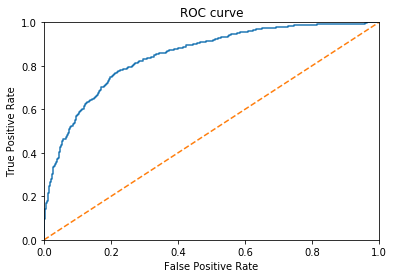

In [46]:
#Calculates the ROC for the model for the testing data set
probabilities_test = random_forest_model_test.predict_proba(features_test)
probabilities_one_test = probabilities_test[:, 1]

fpr, tpr, thresholds = roc_curve(target_test, probabilities_one_test)

plt.figure()
plt.plot(fpr, tpr)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC curve')

# ROC curve for random model
plt.plot([0, 1], [0, 1], linestyle='--')

plt.show()

In [47]:
#Calculates AUC-ROC
auc_roc = roc_auc_score(target_test, probabilities_one_test)

print('The AUC-ROC for the selected model is {:.3f}.'.format(auc_roc))

The AUC-ROC for the selected model is 0.848.


The selected model has an AUC-ROC of 0.848 which is well above the AUC-ROC of the random answer model (0.5). The model has met the required F1 Score and has passed the sanity check.
<a id='Conclusion'></a>
## Conclusion

The purpose of this project was to develop a model that predicts whether a Beta Bank customer will leave the bank soon. The model was trained based on data from previous clients' behavior and past terminations, split into three separate datasets: a training, validation, and testing dataset. The model quality was quantified based on the F1 Score.

The model was initially trained with the raw dataset, which was severeley imbalanced. However, this resulted in an F1 Score well below the required value. Class balancing was fixed via two methods: setting the `class_weight` equal to 'balanced', and by upsampling the positive target data. Retraining the model with the balanced data increased the quality of the models and resulted in an acceptable F1 Score.

From the various iterations of Random Forest and Decision Tree models trained and tested against the validation dataset, a Random Forest model with 40 `n_estimators` and a `max_depth` of 8 proved to have the highest F1 Score on the validation dataset. This specific model was trained on the combined training and validation datasets and then tested against the testing dataset, resulting in an acceptable F1 Score of 0.59. To confirm the model quality was accurate, the AUC-ROC was plotted and compared to a random answer model, which verified the model's quality.